In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Part 1 - Exploratory Data Analysis (EDA)

#### Before we build a model, let's get familiar with the data

In [2]:
df = pd.read_csv('marketing_data.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,halloween,search_non_branded,search_branded,twitter_prospecting,facebook_prospecting,linear_tv,facebook_retargeting,revenue,year
0,2022-01-03,0,2.5,57.5,41774.56658,33448.5,7864.0,1020.7,144094.0,2022
1,2022-01-10,0,56.5,28.4,40850.58012,21120.1,4056.1,583.4,112470.0,2022
2,2022-01-17,0,25.6,33.0,43472.97550,16078.0,3675.0,846.9,112694.0,2022
3,2022-01-24,0,88.6,5.6,63443.29117,25175.5,11248.9,833.1,163208.0,2022
4,2022-01-31,0,33.6,9.9,55503.63088,19062.3,21.8,631.9,160984.0,2022


In [3]:
spend_vars = [
    'search_branded',
    'search_non_branded',
    'linear_tv',
    'facebook_prospecting',
    'twitter_prospecting',
    'facebook_retargeting'
]

control_vars = ['halloween']

date_var = 'date'

kpi = 'revenue'

## Let's view spend and revenue over time

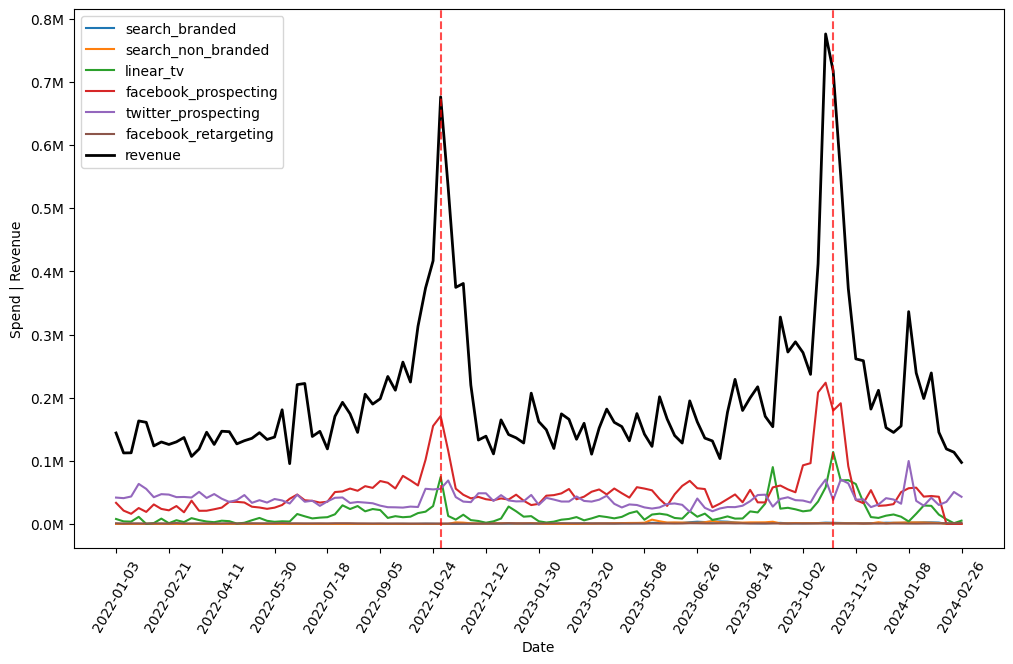

In [4]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(12, 7))

for col in spend_vars:
    plt.plot(df[date_var], df[col], label=col)

plt.plot(df[date_var], df[kpi], label=kpi, linewidth=2, color='black')

halloween_dates = df[df['halloween'] == 1][date_var]
for halloween_date in halloween_dates:
    plt.axvline(halloween_date, color='red', linestyle='--', alpha=0.7)
    
# Define a function to format y-axis values in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'


# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(df[date_var][::7], rotation=60)
plt.xlabel('Date')
plt.ylabel('Spend | Revenue')
plt.legend()
plt.show()


## Spend summed by year

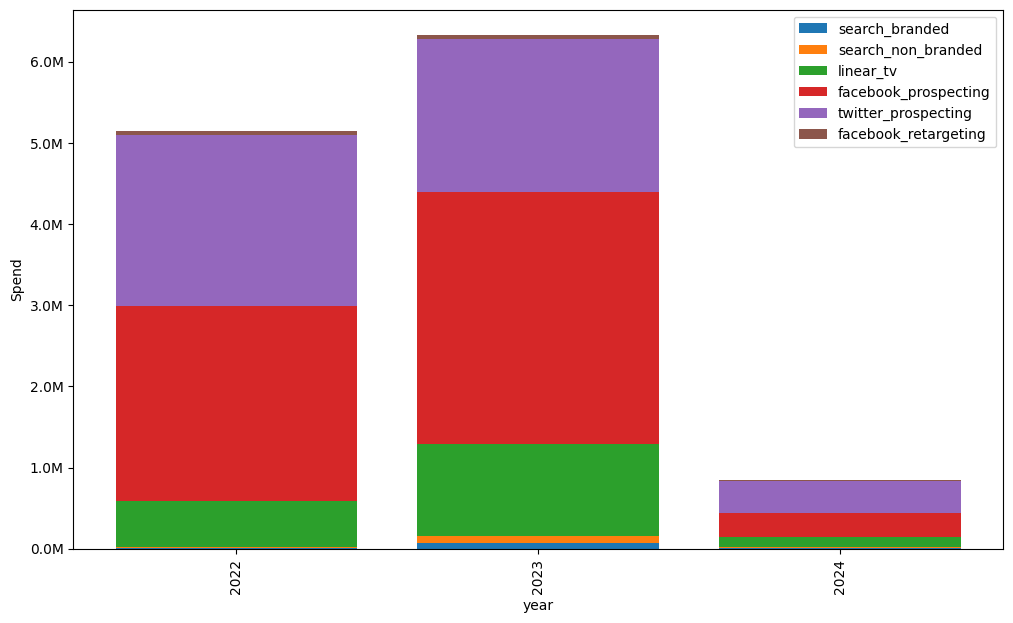

In [5]:
df['year'] = df['date'].dt.year
sum_by_year = df.drop('date', axis=1).groupby(['year']).sum()

plt.figure(figsize=(12, 7))

# Create a stacked bar plot
bottom = None
for col in spend_vars:
    plt.bar(sum_by_year.index, sum_by_year[col], label=col, bottom=bottom)
    if bottom is None:
        bottom = sum_by_year[col].values
    else:
        bottom += sum_by_year[col].values

plt.ylabel('Spend')
plt.xlabel('year')
plt.legend()
plt.xticks(sum_by_year.index, rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()


## Spend summed by channel

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


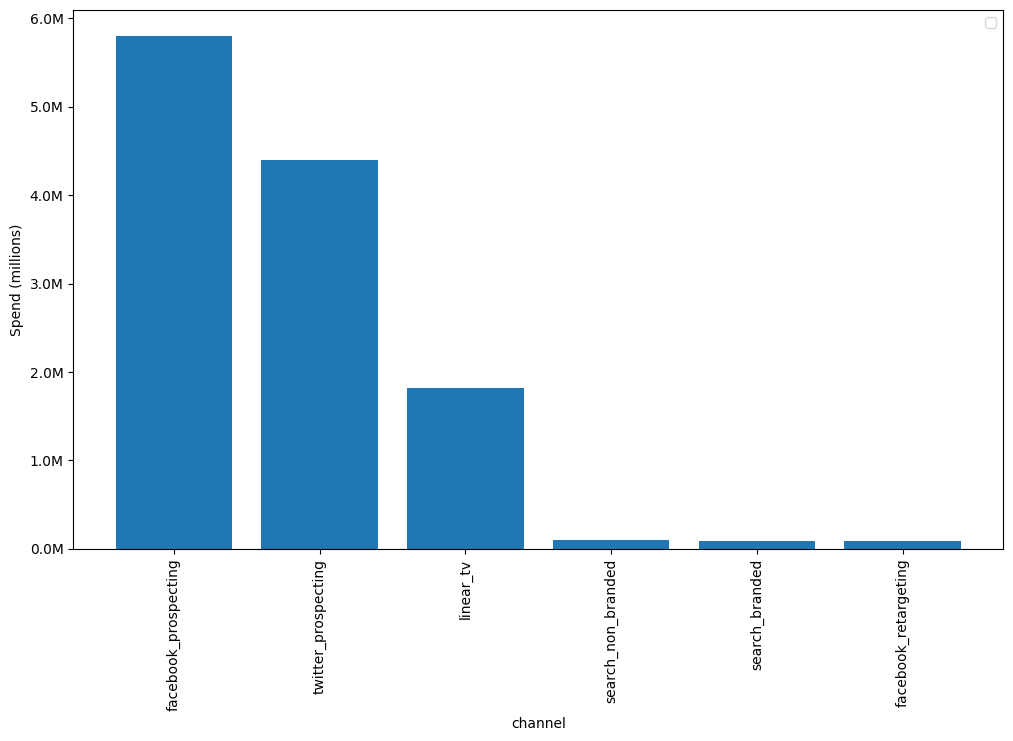

In [6]:
sum_by_channel = df[spend_vars].sum()
sum_by_channel.sort_values( ascending=False, inplace=True)

plt.figure(figsize=(12, 7))

plt.bar(sum_by_channel.index, sum_by_channel.values)

plt.ylabel('Spend (millions)')
plt.xlabel('channel')
plt.legend()
plt.xticks(sum_by_channel.index, rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()

# EDA Summary

#### We can see that our data includes weekly values of spend for each channel as well as revenue from Jan-2022 to Feb-2024. We also have a column tracking halloween dates. This amount of data should be adequate for modeling purposes. As a rule of thumb, 18-24 months is sufficient for MMM.

#### Next, we see that total spend has been about 5M per year (2023 slightly above 2022), and the lion's share of spend has gone into twitter, facebook, and linear_tv. 

#### We also see that we don't have data for exogenous variables such as COVID, consumer confidence, GDP, etc. Although many analysts include these variables in their MMM models, see this [blog post](https://getrecast.com/non-marketing-baseline-mmm-exogenous-factors/) from Recast about the potential hazards of including non-marketing factors in your model. 

#### Finally, there appears to be some seasonal peaks around Halloween each year (no surprise in the candy biz). We have a variable for Halloween dates but don't include a variable for general seasonality. No worries because PyMC will make one for us! However, we should be cautious about controlling for seasonality rather than [modeling it](https://getrecast.com/seasonality/).

#### From this brief analysis we may anticipate that our highest spend channels will likely have the biggest impact on revenue. Of course, that does not mean they are the most efficient! In any case, we can use the spend values to inform our beta priors.

# Part 3 - Model Specification and Fitting

#### We will use [PyMC-Marketing](https://www.pymc-marketing.io/en/stable/) to build our MMM model. This library provides a user-friendly bayesian implemention of MMM with lots of cool features and plotting functions.

In [7]:
# Split data into X, y and train/test
# For validation, we want to hold out the last 15% of the timeseries

# X, y
X = df.drop(kpi, axis=1)
y = df[kpi] 


#Split train and test
split_index = int(0.85 * len(df))

df_train = df.iloc[:split_index]
X_train = df_train.drop(kpi, axis=1)
y_train = df_train[kpi]


df_test = df.iloc[split_index:]
X_test = df_test.drop(kpi, axis=1)
y_test = df_test[kpi]

In [8]:
# Use spend values in each channel to generate sigma priors for each of the paid media channels
spend_by_channel = df[spend_vars].sum(axis=0)
spend_share = spend_by_channel / spend_by_channel.sum()

HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = len(spend_vars)

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_sigma.tolist()

[0.07355764010250829,
 0.08583957340936114,
 1.474223447066364,
 4.690056647338848,
 3.5576481530343074,
 0.07205497887044882]

In [32]:
#set model congifuration with our priors for each parameter

mmm_config = {
    'intercept': {'dist': 'LogNormal', 
                  'kwargs': {'mu': 0.5, 'sigma': 2}},
   
    'beta_channel': {'dist': 'LogNormal', # parameters for our media channels
                     'kwargs': {'mu':1, 'sigma': prior_sigma}},   #use our calculated sigmas from above
    
    'alpha': {'dist': 'Beta', # parameter for adstock function for medial channels
              'kwargs': {'alpha': 1, 'beta': 3}},
    
    'lam': {'dist': 'Gamma',  # parameter for the saturation function for media channels
            'kwargs': {'alpha': 3, 'beta': 1}},
    
    'likelihood': {'dist': 'Normal', 
                   'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},

    'gamma_control': {'dist': 'Normal', # parameter for any control variables (halloween)
                      'kwargs': {'mu': 0, 'sigma': 1}},

    'gamma_fourier': {'dist': 'Laplace', # parameter for fourier series to model seasonality
                      'kwargs': {'mu': 0, 'b': 3}}
            }

In [10]:
#want to see progress as the model trains
sampler_config= {"progressbar": True}

In [11]:
#build the model
mmm = DelayedSaturatedMMM(
    model_config = mmm_config,
    sampler_config = sampler_config,
    date_column = date_var,
    channel_columns = spend_vars,
    control_columns = control_vars,
    adstock_max_lag=8,
    yearly_seasonality=1,
)

In [12]:
#fit the model!
mmm.fit(X=X_train, y=y_train, target_accept=0.95, chains=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, gamma_fourier, likelihood_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

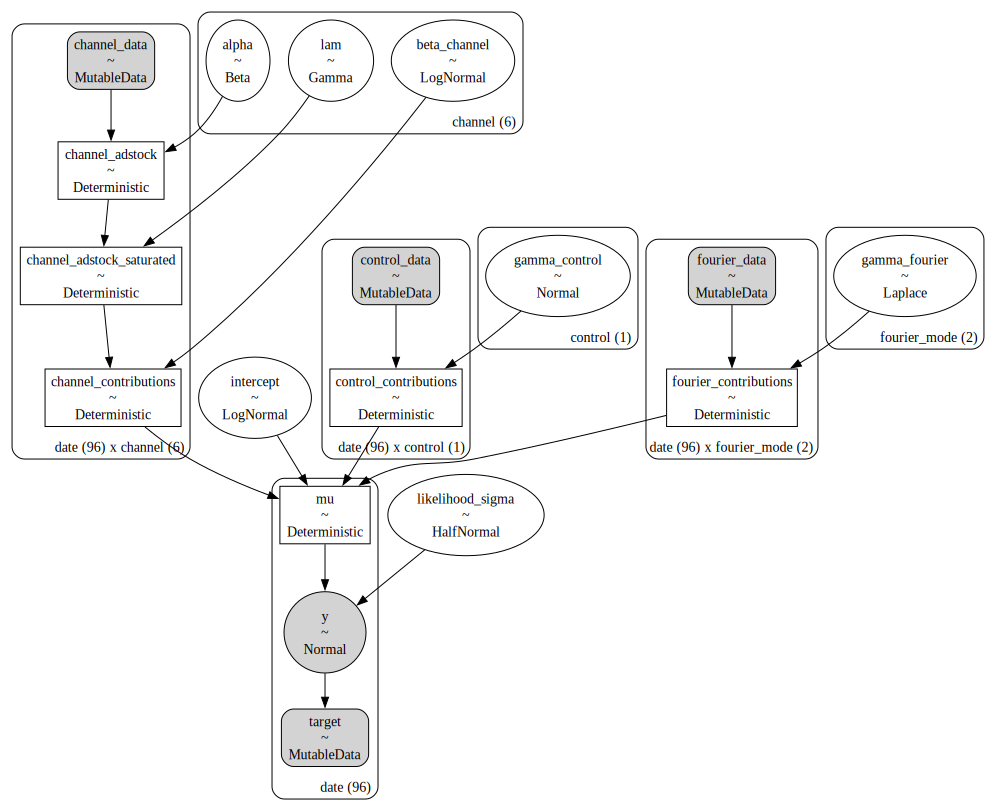

In [13]:
# Show the model structure
pm.model_to_graphviz(model=mmm.model)

# Part 4 - Model Review

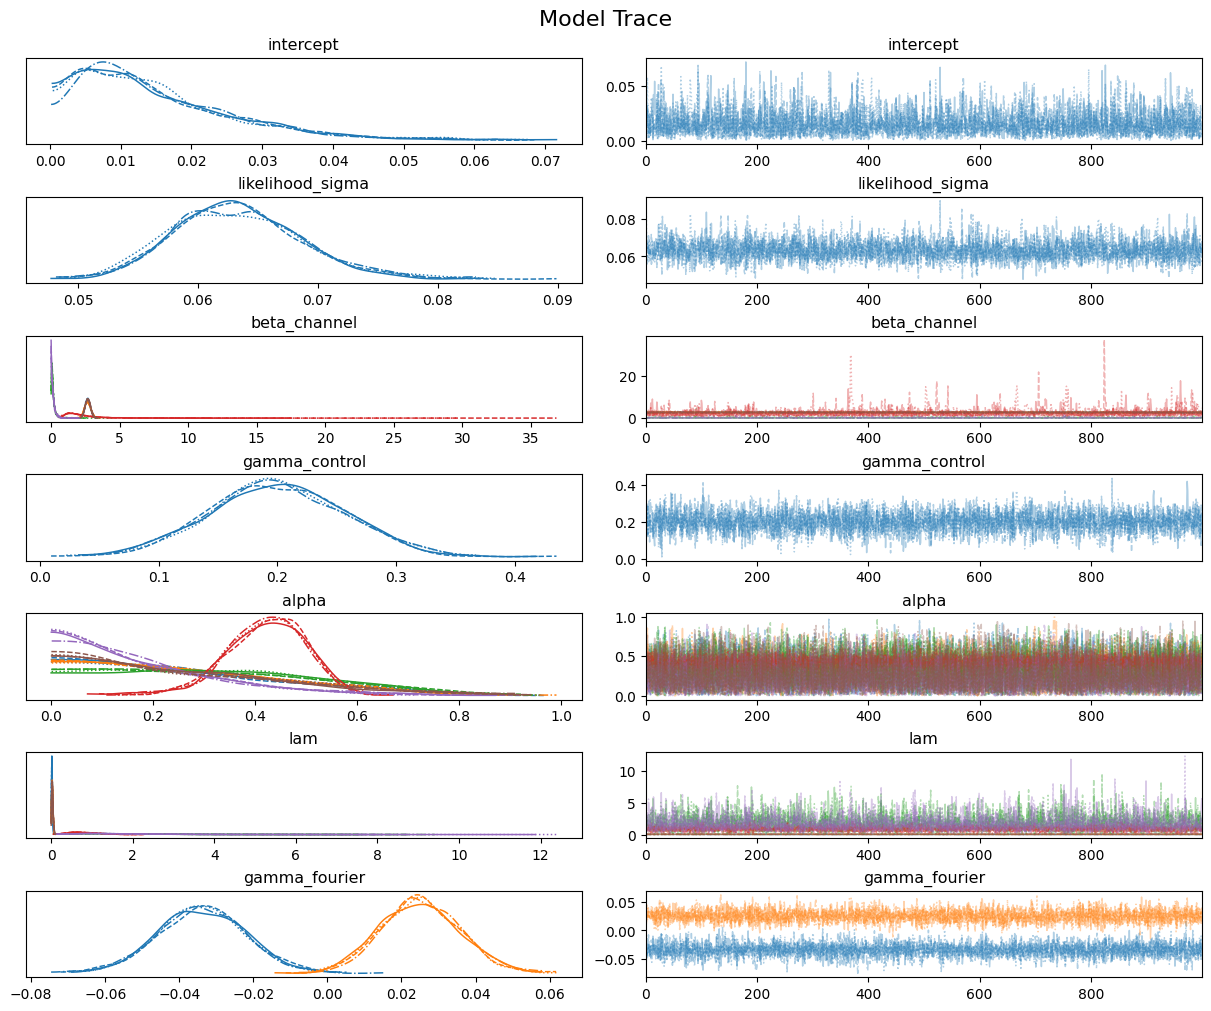

In [14]:
#plot the posterior distributions for the parameters

_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "gamma_control",
        "alpha",
        "lam",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Sampling: [y]


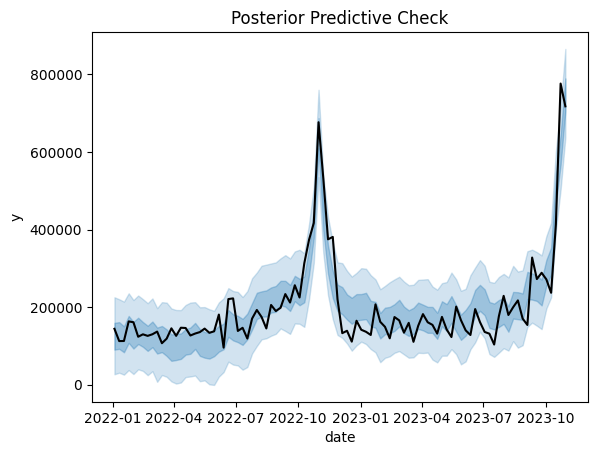

In [15]:
#Check how well the model retrodicts the training data by sampling the posterior predictive

y_train_pred = mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)
mmm.plot_posterior_predictive(original_scale=True);

In [33]:
# r2 on training data
from sklearn.metrics import r2_score

y_train_pred_mean = y_train_pred['y'].mean(dim='sample').values

r_squared_training = r2_score(y_train, y_train_pred_mean)

r_squared_training

0.852516767522893

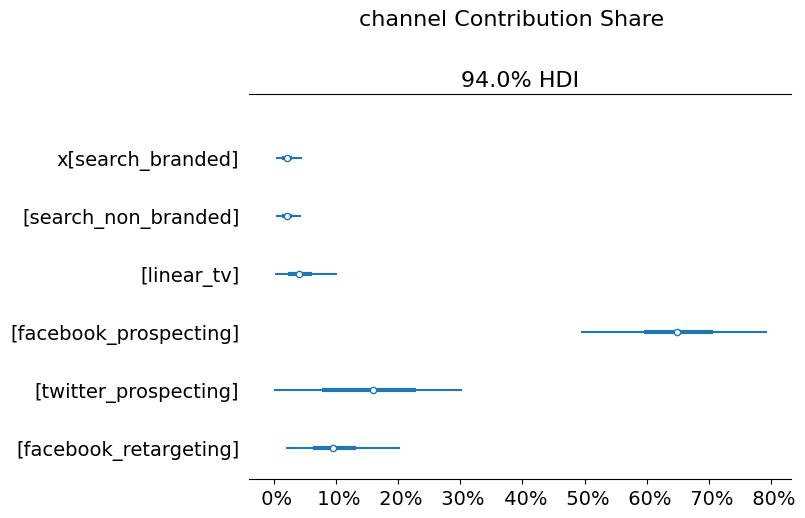

In [17]:
#what are the channel contributions to revenue?

fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))

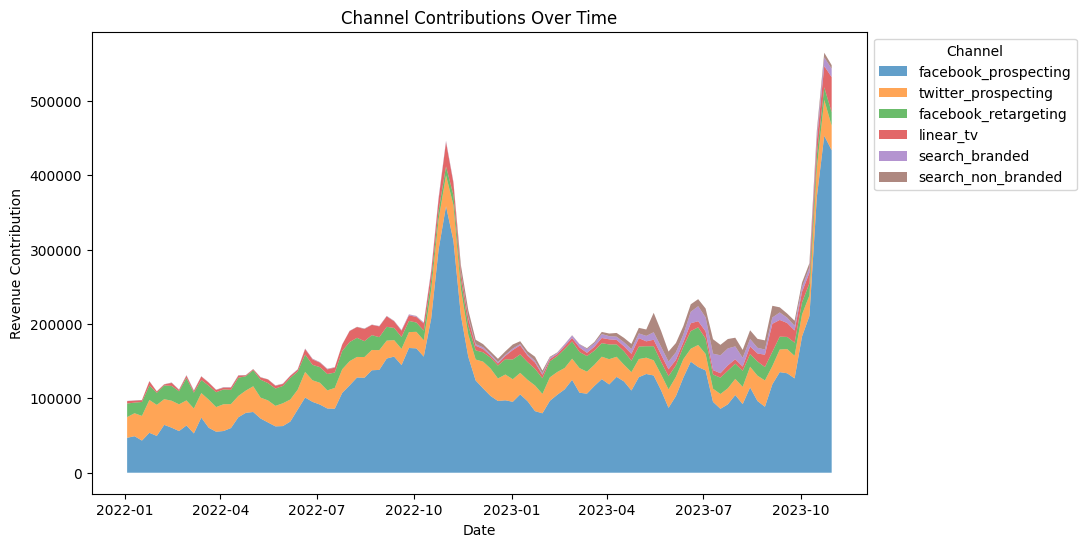

In [18]:
# let's see channel contributions over time

df_attribution = (
    mmm.compute_channel_contribution_original_scale()
    .mean(dim=('chain','draw'))
    .to_dataframe(name='attribution')
    .reset_index()
    .pivot(index='date', columns='channel', values='attribution')
    .reset_index()
    .rename_axis(None, axis=1)
)

column_order = df_attribution.drop('date', axis=1).sum(axis=0).sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(10, 6))

bottom = 0  # Initialize bottom value for stacking

for channel in column_order:
    ax.fill_between(df_attribution['date'], bottom, bottom + df_attribution[channel], label=channel, alpha=0.7)
    bottom += df_attribution[channel]

plt.xlabel('Date')
plt.ylabel('Revenue Contribution')
plt.title('Channel Contributions Over Time')
plt.legend(title='Channel', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

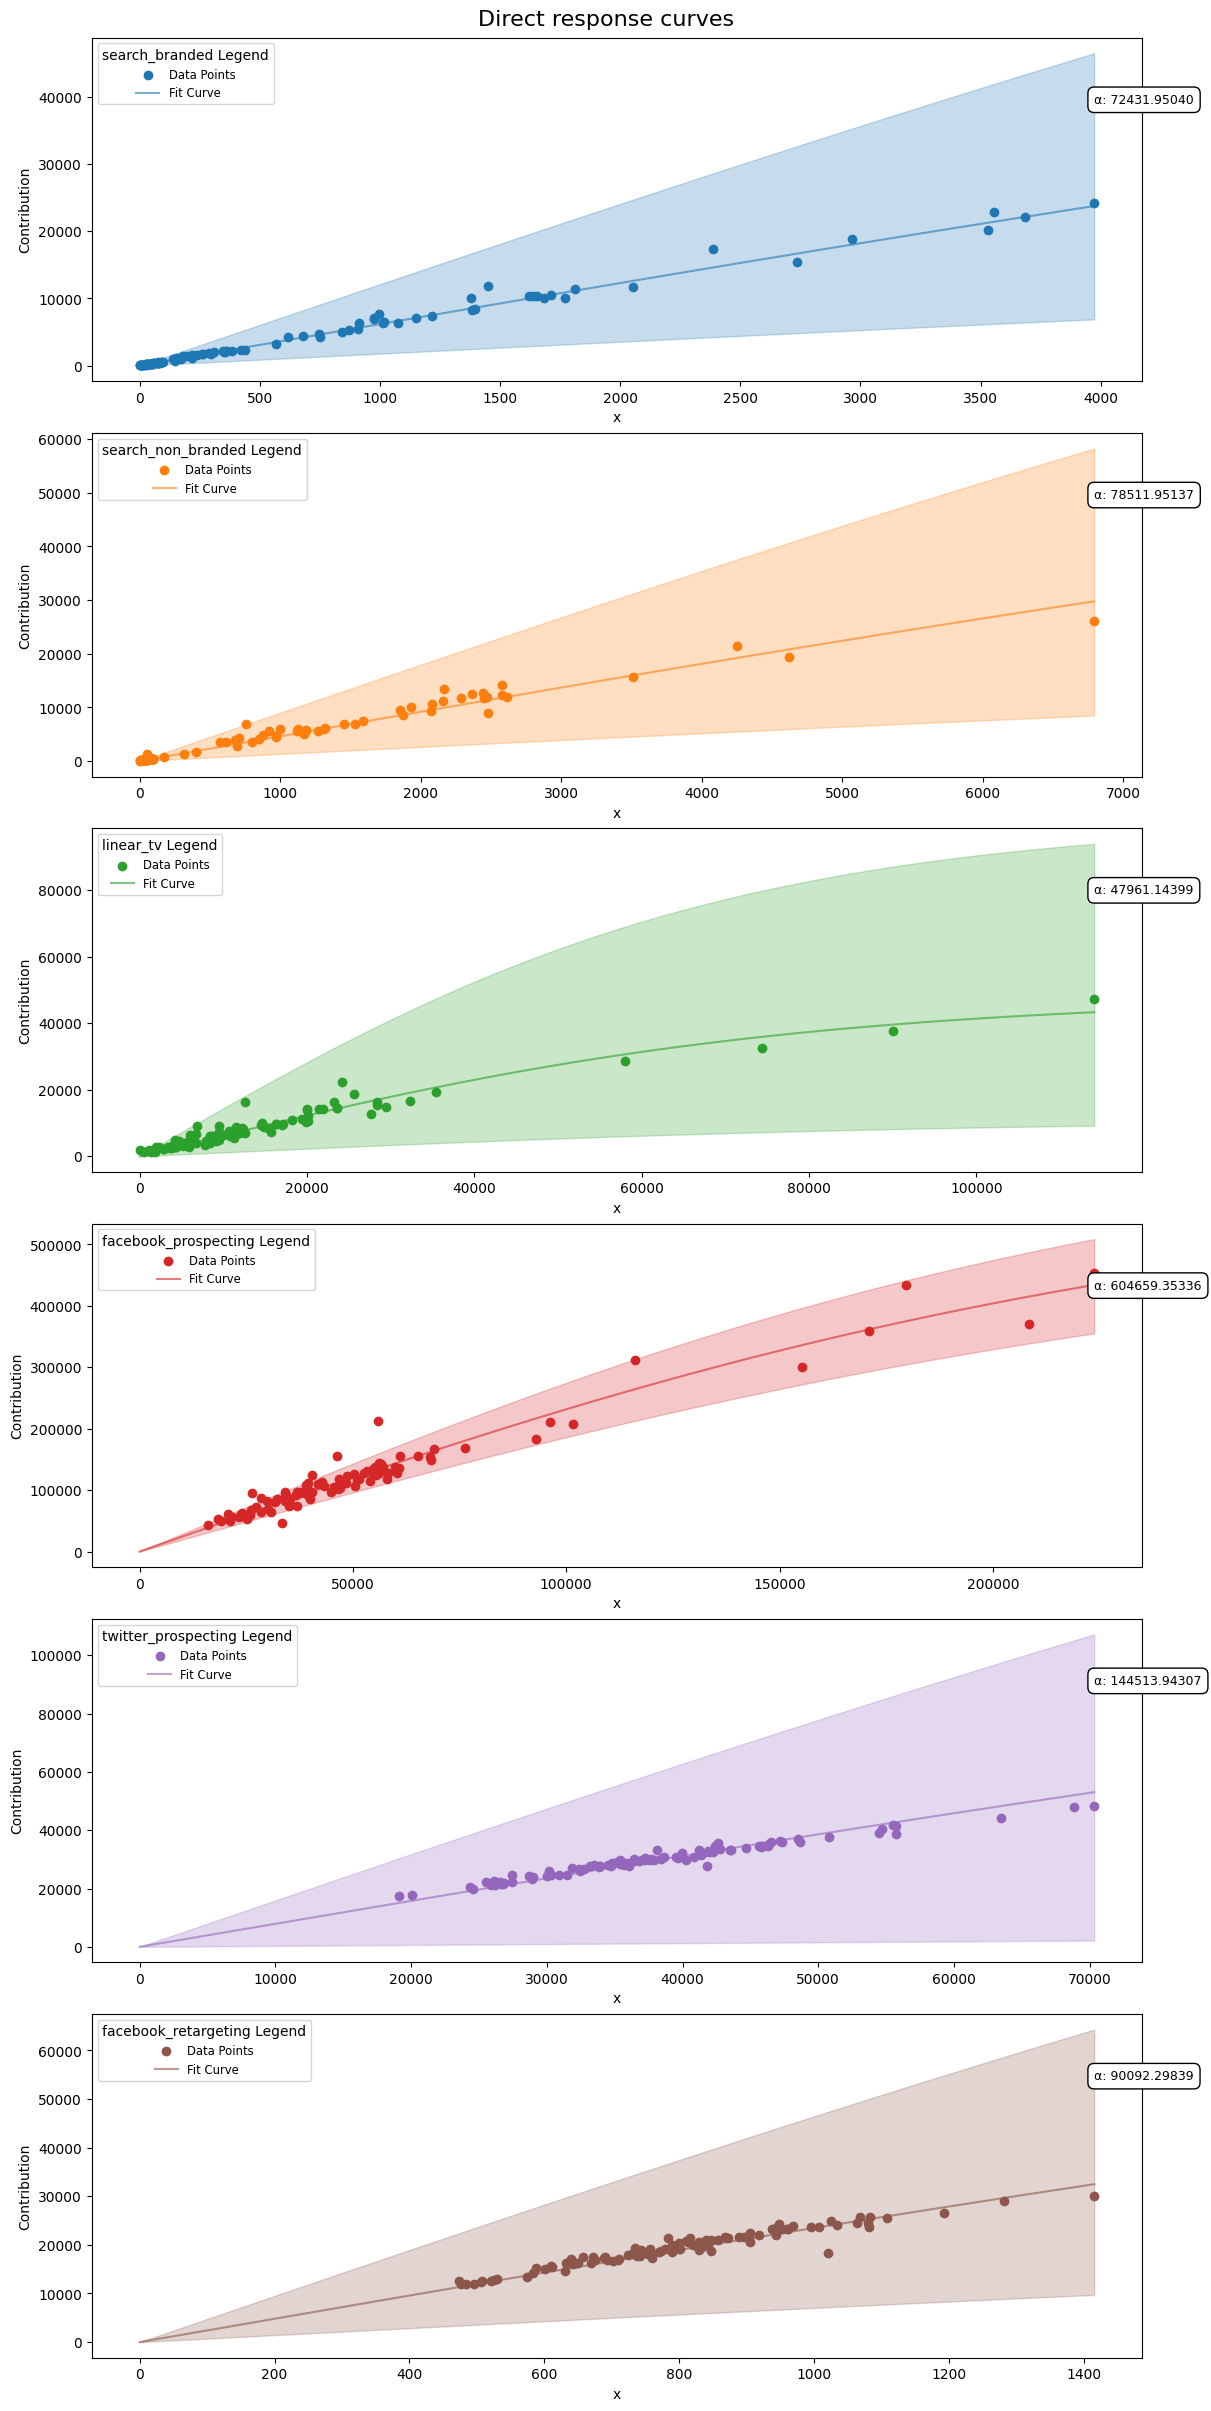

In [34]:
#we can see where every week's spend falls on each channel's saturation curve

fig = mmm.plot_direct_contribution_curves(show_fit=True)
[ax.set(xlabel="x") for ax in fig.axes];

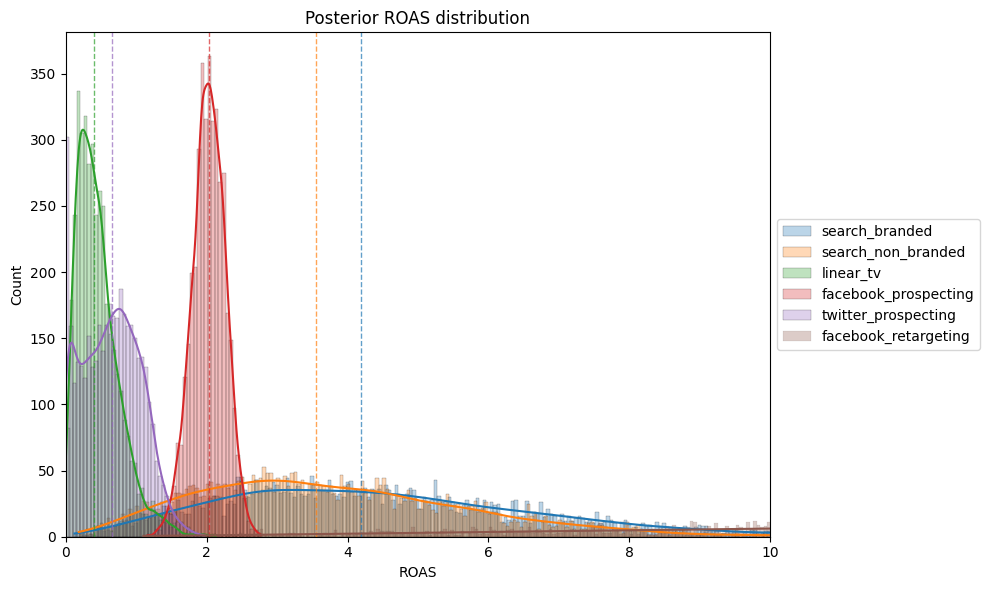

In [20]:
#plot the ROAS distributions for each channel

channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / X[spend_vars].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
for channel in spend_vars:
    data = roas_samples.sel(channel=channel).to_numpy()
    histplot = sns.histplot(data, label=channel, binwidth=0.05, alpha=0.3, kde=True, ax=ax)
    color = ax.lines[-1].get_color()

    # Calculate and display mean for each channel"
    median_value = np.median(data)
    ax.axvline(median_value, linestyle='dashed', color=color, alpha=0.7, linewidth=1)

ax.set_xlim(0,10)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS")
plt.tight_layout()

In [21]:
#let's get one number for ROAS for each channel
roas_samples.median(dim='sample').to_dataframe(name='median_ROAS').sort_values(by='median_ROAS',ascending=False)

,median_ROAS
channel,
facebook_retargeting,19.283301
search_branded,4.197751
search_non_branded,3.554372
facebook_prospecting,2.032508
twitter_prospecting,0.655755
linear_tv,0.397661


# Model Evaluation Summary

#### In the above section we examined our model outputs and can draw the following conclusions:
1. Our model is able to retrodict the data well. We get an r2 of on the training data of ~0.85
2. Facebook_prospecting contributed the most to revenue out of all 6 channels, accounting for ~65% of the total paid media contribution.
   - Note that the uncertainty for this estimate is large, ranging from ~50% to ~80%
3. Of the upper-funnel channels, linear TV contributed the least, accounting for ~7% of revenue despite accounting for 15% of spend
4. Return on Ad Spend (ROAS) was highest for facebook_retargeting at a median value of 19 (suspiciously high) and lowest for linear_tv at 0.39.


#### Before we share these results with the marketing team, let's validate the model on the unseen test data

# Part 5 - Model Validation

#### How can we be sure our model will do well going forward? We'll use out-of-sample predictive accuracy!

In [22]:
# Generate predictions on the test set

y_test_pred = mmm.sample_posterior_predictive(X_pred=X_test, extend_idata=False, include_last_observations=True)

y_test_pred

Sampling: [y]


<xarray.Dataset>
Dimensions:  (date: 17, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2023-11-06 2023-11-13 ... 2024-02-26
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6.602e+05 6.578e+05 ... 1.03e+05 1.014e+05
Attributes:
    created_at:                 2024-02-21T18:46:26.218525
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

/var/folders/lz/v_htln5x1l79lyrgc2h1xw9c0000gn/T/ipykernel_92535/59135376.py:17: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_out_of_sample["date"].dt.to_pydatetime(),


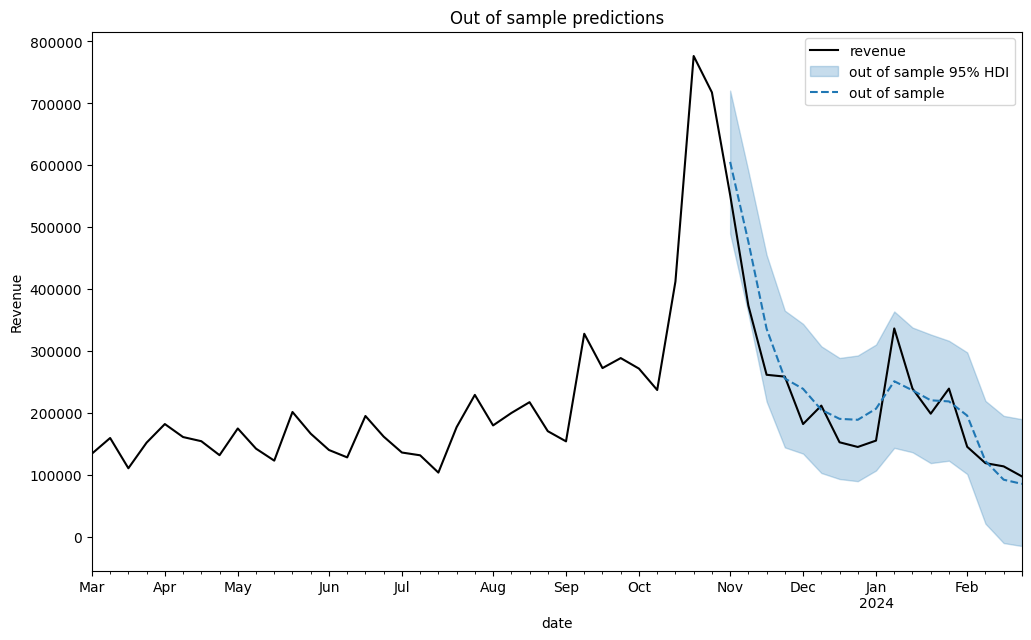

In [23]:
# How well does our model predict out of sample data at the end of the time series?

def plot_in_sample(X, y, ax, n_points: int=0):
    (
        y.to_frame()
        .set_index(X["date"])
        .iloc[-n_points:]
        .plot(ax=ax, color="black", label="actuals")
    )
    
def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label): 
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")
    
    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample["date"].dt.to_pydatetime(), 
        conf[lower], 
        conf[upper], 
        alpha=0.25, 
        color=color, 
        label=f"{label} 95% HDI", 
    )
    
    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, label=label, color=color, linestyle="--")
    ax.set(
        ylabel="Revenue", 
        title="Out of sample predictions"
    )

    return ax


fig, ax = plt.subplots(figsize=(12,7))
plot_in_sample(X, y, n_points=52, ax=ax)
plot_out_of_sample(X_test, y_test_pred, ax=ax, label="out of sample", color="C0")
ax.legend();
plt.show()

In [24]:
#Check the r2 using the mean of the y_test_pred posterior

y_test_pred_mean = y_test_pred['y'].mean(dim='sample').values

r_squared_test = r2_score(y_test, y_test_pred_mean)

r_squared_test

0.8110828231455954

# Part 6 - Budget Optimization

#### In the next month, Sweetums has 1M to spend on their paid media. Where should they put it?

In [25]:
total_budget = 1 #1M USD

#The initial split per channel
budget_per_channel = total_budget / n_channels

#Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in spend_vars}

#bounds for each channel - minimum 1k, maximum 700k
min_budget, max_budget = .001, 0.75 
budget_bounds = {channel: [min_budget, max_budget] for channel in spend_vars}

In [26]:
#calculate parameters for sigmoid function
sigmoid_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='sigmoid')

/Users/phil/.asdf/installs/python/3.11.7/lib/python3.11/site-packages/pymc_marketing/mmm/base.py:920: UserWarning: The curve optimization parameters method is experimental
  warnings.warn(


In [27]:
result_sigmoid = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid', #define saturation function
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = budget_bounds
)

result_sigmoid

/Users/phil/.asdf/installs/python/3.11.7/lib/python3.11/site-packages/pymc_marketing/mmm/base.py:890: UserWarning: This budget allocator method is experimental
  warnings.warn("This budget allocator method is experimental", UserWarning)


,estimated_contribution,optimal_budget
search_branded,1.526509,0.246
search_non_branded,0.004612,0.001
linear_tv,0.000626,0.001
facebook_prospecting,0.002440,0.001
twitter_prospecting,0.000791,0.001
facebook_retargeting,18.022360,0.750
total,19.557338,1.000


#### Obviously we can't dump all our money into facebook_retargeting when we've never spent more than 6K on that channel in a month. Let's set the upper limit on that channel to 100k and try again. Let's also restrain the lower funnel channels to 50k max.

In [28]:
budget_bounds['facebook_retargeting'] = [.001, .1]
budget_bounds['search_non_branded'] = [.001, .05]
budget_bounds['search_branded'] = [.001, .05]

budget_bounds

{'search_branded': [0.001, 0.05],
 'search_non_branded': [0.001, 0.05],
 'linear_tv': [0.001, 0.75],
 'facebook_prospecting': [0.001, 0.75],
 'twitter_prospecting': [0.001, 0.75],
 'facebook_retargeting': [0.001, 0.1]}

In [29]:
result_sigmoid = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid', #define saturation function
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = budget_bounds
)

result_sigmoid

/Users/phil/.asdf/installs/python/3.11.7/lib/python3.11/site-packages/pymc_marketing/mmm/base.py:890: UserWarning: This budget allocator method is experimental
  warnings.warn("This budget allocator method is experimental", UserWarning)


,estimated_contribution,optimal_budget
search_branded,0.310266,0.050
search_non_branded,0.230617,0.050
linear_tv,0.000626,0.001
facebook_prospecting,1.830131,0.750
twitter_prospecting,0.038757,0.049
facebook_retargeting,2.402981,0.100
total,4.813378,1.000


In [30]:
#Use the function `calculate_expected_contribution` to estimate
#the contribution of your initial budget based on the curve parameters.
from pymc_marketing.mmm.budget_optimizer import calculate_expected_contribution

initial_contribution = calculate_expected_contribution(
    method='sigmoid',
    parameters = sigmoid_params,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict
}

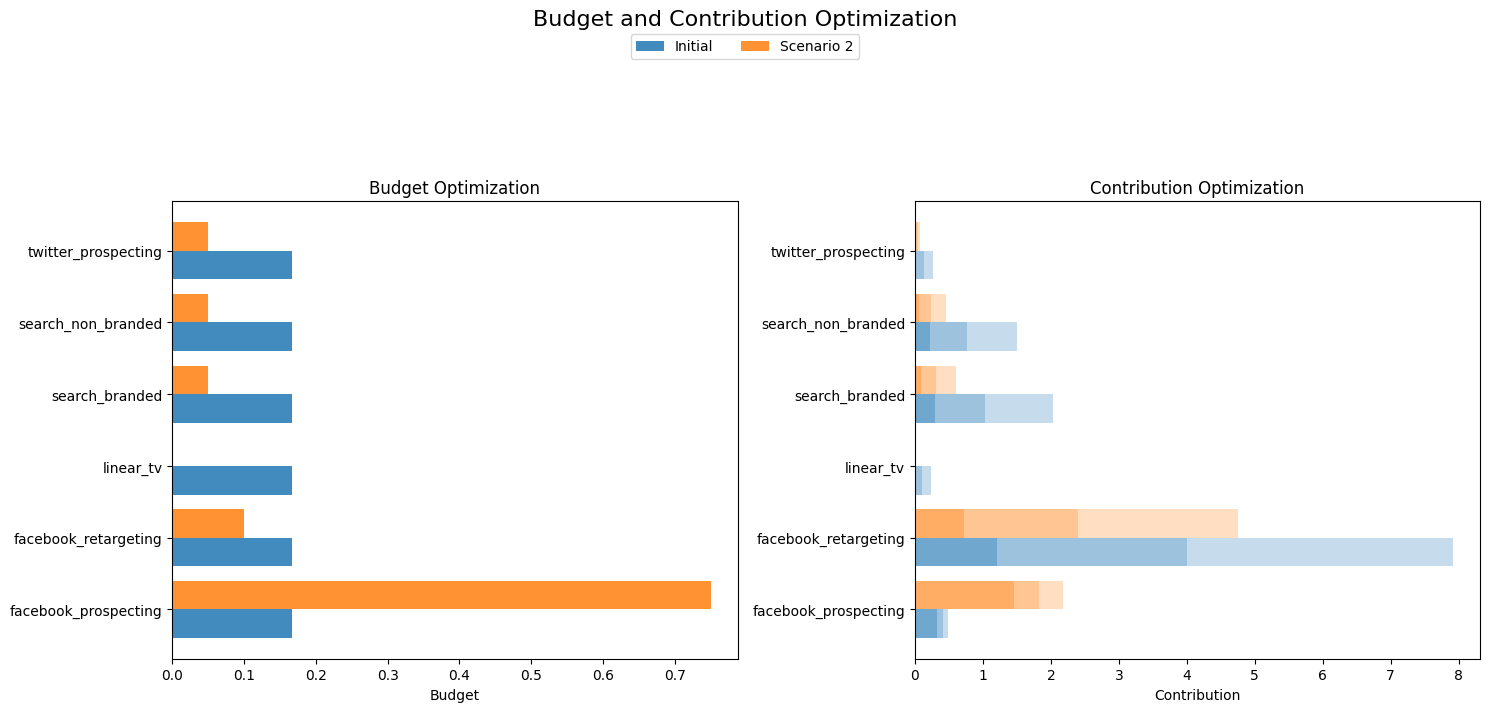

In [31]:
figure_ = mmm.plot_budget_scenearios(base_data=initial_scenario, method='sigmoid', scenarios_data=[result_sigmoid])

## Budget Optimization Summary

#### The results of this work suggest that we should invest our maximum threshold (750k) in facebook_prospeting and facebook_retargeting (100k). Reduce spend to a minimum in linear_tv.

# Part 6 - Stakeholder Readout

## Summary

#### Using PyMC, we constructed a bayesian MMM model to estimate the efficiency of paid media at JellyPop. Modeling the period of Jan 2022 through Feb 2024, we have extracted the following top-level insights:
1. Facebook is performing the best (both prospecting and retargeting). Our budget optimization supports that both of these channels should receive the maximum tolerable investment. The ROAS for facebook_prospecting is hovering around 2, for facebook_retargeting it is 19*.
2. Linear_tv and twitter_prospecting are performing very poorly. These channels have an ROAS that is <1, meaning they earn us less money than we spend into them. Reduce spend in these channels to a minimum.
3. Including some constraints on the upper and lower bounds of channel investments, we recommend spending up to 750k in facebook_prospecting, 100k in facebook_retargeting, 50k in twitter_prospecting, and 10K in linear_tv.

*This value is aberrantly high and likely reflects an incomplete understanding of this channel.


## Caveats

#### While a strong version 1, this model is not perfect. As with any model, these estimates come with error. For example, the uncertainty esimates around the saturation curves speak to the fact that there is a wide range of plausible response curves for each of our channels. This error is also reflected in the channel contributions plot (e.g. twitter_prospecting contributes anywhere from 0-30%).

#### Furthermore, while this model displays a high out-of-sample predictive accuracy (r2 = 0.81), we have no historical experimental data with which to strengthen the claim that we have developed a causal model. We would recommend running experiments in which we temporarily reduce spend in media channels at different times. This kind of experimental control will provide the strongest evidence that we have found a causal model while also reducing the uncertainty around the channel-level estimates.
